In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = 8, 5

import warnings
warnings.filterwarnings('ignore')

#### Time Series Data Analysis
- 수집처 : https://www.blockchain.com/ko/chart/market-price?time=60days

In [2]:
# 데이터 읽기.
bitcoin_df = pd.read_csv('data10/market-price.csv')
bitcoin_df.columns = ['day', 'price']
bitcoin_df.head(10)

,day,price
0,2017-08-28 00:00:00,4391.673517
1,2017-08-29 00:00:00,4607.985450
2,2017-08-30 00:00:00,4594.987850
3,2017-08-31 00:00:00,4748.255000
4,2017-09-01 00:00:00,4911.740017
5,2017-09-02 00:00:00,4580.387480
6,2017-09-03 00:00:00,4648.159983
7,2017-09-04 00:00:00,4344.098317
8,2017-09-05 00:00:00,4488.720140
9,2017-09-06 00:00:00,4641.822017


In [3]:
# 데이터 정보 확인.
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     364 non-null    object 
 1   price   364 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
# price 기술 통계량.
bitcoin_df[['price']].describe()

,price
count,364.000000
mean,8406.966752
std,3237.302743
min,3319.630000
25%,6400.127740
50%,7687.758750
75%,9632.419291
max,19498.683333


In [5]:
# object 타입의 day 컬럼을 datetime으로 변경.
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     364 non-null    datetime64[ns]
 1   price   364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [6]:
# day 컬럼을 인덱스로 설정.
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head(10)

,price
day,
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000
2017-09-01,4911.740017
2017-09-02,4580.387480
2017-09-03,4648.159983
2017-09-04,4344.098317
2017-09-05,4488.720140


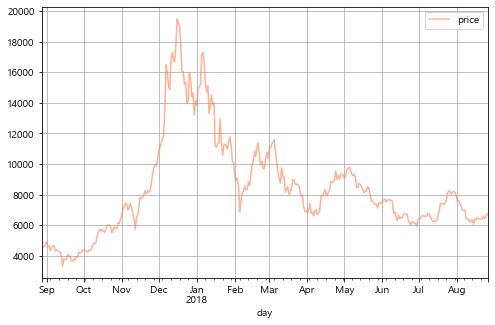

In [7]:
# 일자별 비트코인 시세를 시각화.
# 2017년 12월에서 2018년 1월 사이 급상승.
bitcoin_df.plot(alpha=.6, c='coral')
plt.grid()
plt.show()

In [8]:
# Arima 모델을 결정하기 위한 AIC 함수.
def arima_aic_check(data, order, sort = 'AIC') :
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
                
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [9]:
# AIC 값이 가장 낮은 Arima 모델을 가져옴.
arima_aic_check( bitcoin_df, [3,3,3] ).iloc[0]

order    p:2 d:1 q:2
AIC      5556.408611
Name: 22, dtype: object

In [10]:
# 시세 예측 - ARIMA 모델 적용.
# ARIMA(2,1,2)
model = ARIMA(bitcoin_df['price'].values, order=(2, 1, 2))
model = model.fit(trend='c', full_output=True, disp=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  363
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2772.204
Method:                       css-mle   S.D. of innovations            501.280
Date:                Fri, 19 Mar 2021   AIC                           5556.409
Time:                        21:34:43   BIC                           5579.775
Sample:                             1   HQIC                          5565.697
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2687     26.649      0.235      0.814     -45.962      58.499
ar.L1.D.y     -1.6264      0.045    -36.012      0.000      -1.715      -1.538
ar.L2.D.y     -0.9134      0.039    -23.183      0.000      -0.991      -0.836
ma.L1.D.y      1.6753      0.050     33.290      0.000       1.577       1.774
ma.L2.D.y      0.9099      0.048     19.024      0.000       0.816       1.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8903           -0.5497j            1.0463           -0.4120
AR.2           -0.8903           +0.5497j            1.0463            0.4120
MA.1           -0.9206           -0.5015j            1.0483           -0.4206
MA.2           -0.9206           +0.5015j            1.0483            0.4206
-----------------------------------------------------------------------------
"""

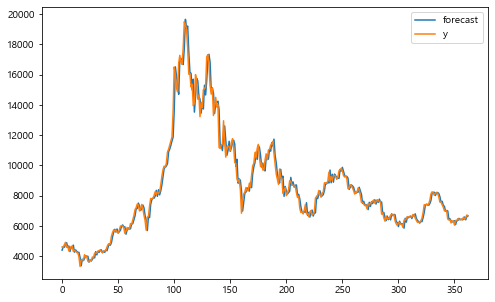

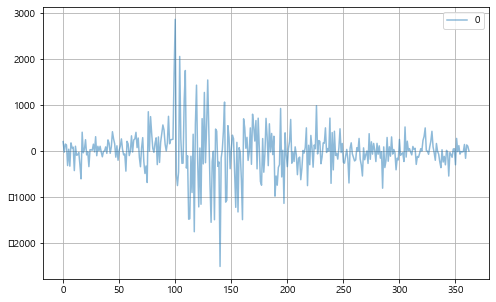

In [11]:
# 모델 성능과 예측 결과 시각화.
# 학습데이터에 대한 예측 결과.
fig = model.plot_predict()
fig
# 변동폭.
residuals = pd.DataFrame(model.resid)
residuals.plot(alpha=.5)
plt.grid()
plt.show()

### 데이터 예측

In [12]:
# 학습 데이터 이후 5일치를 예측.
forecast_data = model.forecast(steps=5)
forecast_data

(array([6722.28353559, 6713.78559754, 6705.03265201, 6749.21984789,
        6707.53823491]),
 array([ 501.27993611,  726.4642422 ,  873.04089147, 1021.04485437,
        1134.20295047]),
 array([[5739.79291465, 7704.77415654],
        [5289.94184677, 8137.62934832],
        [4993.90394771, 8416.16135632],
        [4748.00870673, 8750.43098905],
        [4484.54130083, 8930.53516899]]))

In [13]:
# 테스트 데이터를 불러오기.
bitcon_test_df = pd.read_csv('data10/market-price-test.csv', header=None)
bitcon_test_df.columns = ['day', 'price']
bitcon_test_df

,day,price
0,2018-08-27 00:00:00,6719.266154
1,2018-08-28 00:00:00,7000.040000
2,2018-08-29 00:00:00,7054.276429
3,2018-08-30 00:00:00,6932.662500
4,2018-08-31 00:00:00,6981.946154


In [14]:
# 예측 결과 추출.
pred_y = forecast_data[0].tolist()

# 실제 결과 추출.
test_y = bitcon_test_df['price'].values
print(pred_y)
print(test_y)

[6722.283535591618, 6713.785597543948, 6705.032652013841, 6749.219847891536, 6707.53823491197]
[6719.26615385 7000.04       7054.27642857 6932.6625     6981.94615385]


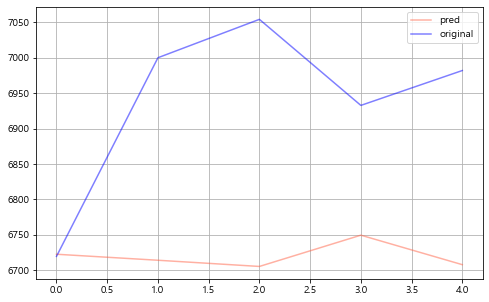

In [15]:
plt.plot(pred_y, label='pred', c='tomato', alpha=.5)
plt.plot(test_y, label='original', c='blue',alpha=.5)
plt.legend()
plt.grid()
plt.show()

In [16]:
# Facebook Prophet 사용.
# conda install -c conda-forge fbprophet
# prophet을 사용하기 위해서는 날짜는 ds, 결과는 y로 설정해야한다.
bitcoin_df = pd.read_csv('data10/market-price.csv')
bitcoin_df.columns = ['ds', 'y']
bitcoin_df.head(10)

,ds,y
0,2017-08-28 00:00:00,4391.673517
1,2017-08-29 00:00:00,4607.985450
2,2017-08-30 00:00:00,4594.987850
3,2017-08-31 00:00:00,4748.255000
4,2017-09-01 00:00:00,4911.740017
5,2017-09-02 00:00:00,4580.387480
6,2017-09-03 00:00:00,4648.159983
7,2017-09-04 00:00:00,4344.098317
8,2017-09-05 00:00:00,4488.720140
9,2017-09-06 00:00:00,4641.822017


In [17]:
# prophet 생성.
# seasonlity_mode : 트랜드 분석 방식을 설정.
# multiplicative를 주면 다양한 기준으로 분석을 하게함.
# yearly_seasonality : 연간 트랜드
# weekly_seasonality : 주간 트랜드
# daily_seasonality : 일단 트랜드

prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=True,
                  changepoint_prior_scale=0.5 )
prophet.fit(bitcoin_df)

In [18]:
# 모델로 부터 예측할 기간을 정의하고, 결과를 도출.
# 5일을 내다보며 예측.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-08-28,514.101377,3830.331434,5112.750223,514.101377,514.101377,9.457526,9.457526,9.457526,7.683004,...,-0.005599,-0.005599,-0.005599,-1.768923,-1.768923,-1.768923,0.0,0.0,0.0,4463.944333
1,2017-08-29,518.326085,3887.096383,5251.150435,518.326085,518.326085,9.457526,9.457526,9.457526,7.735229,...,0.021268,0.021268,0.021268,-1.743565,-1.743565,-1.743565,0.0,0.0,0.0,4527.697290
2,2017-08-30,522.550792,3850.560643,5220.713042,522.550792,522.550792,9.457526,9.457526,9.457526,7.667513,...,-0.054768,-0.054768,-0.054768,-1.735245,-1.735245,-1.735245,0.0,0.0,0.0,4529.215917
3,2017-08-31,526.775499,3910.019583,5264.255087,526.775499,526.775499,9.457526,9.457526,9.457526,7.691876,...,-0.019726,-0.019726,-0.019726,-1.745924,-1.745924,-1.745924,0.0,0.0,0.0,4578.667157
4,2017-09-01,531.000207,3955.773290,5319.436080,531.000207,531.000207,9.457526,9.457526,9.457526,7.718889,...,0.038328,0.038328,0.038328,-1.776965,-1.776965,-1.776965,0.0,0.0,0.0,4629.731829


In [19]:
# 예측 결과.
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
364,2018-08-27,804.038997,6266.365763,7677.504613,804.038997,804.038997,9.457526,9.457526,9.457526,7.631219,...,-0.005599,-0.005599,-0.005599,-1.820708,-1.820708,-1.820708,0.0,0.0,0.0,6939.836961
365,2018-08-28,809.044553,6277.925649,7750.544126,809.044553,809.044553,9.457526,9.457526,9.457526,7.701153,...,0.021268,0.021268,0.021268,-1.777642,-1.777642,-1.777642,0.0,0.0,0.0,7039.620143
366,2018-08-29,814.050110,6314.604876,7765.872880,814.048365,814.050110,9.457526,9.457526,9.457526,7.654362,...,-0.054768,-0.054768,-0.054768,-1.748396,-1.748396,-1.748396,0.0,0.0,0.0,7045.084390
367,2018-08-30,819.055666,6387.807933,7840.907039,810.820002,820.469536,9.457526,9.457526,9.457526,7.702189,...,-0.019726,-0.019726,-0.019726,-1.735611,-1.735611,-1.735611,0.0,0.0,0.0,7127.577427
368,2018-08-31,824.061223,6375.617264,7973.022819,804.129014,833.289373,9.457526,9.457526,9.457526,7.754465,...,0.038328,0.038328,0.038328,-1.741388,-1.741388,-1.741388,0.0,0.0,0.0,7214.215542


In [20]:
# 날짜와 예측 결과.
forecast_data[['ds', 'yhat']].tail(5)

,ds,yhat
364,2018-08-27,6939.836961
365,2018-08-28,7039.620143
366,2018-08-29,7045.084390
367,2018-08-30,7127.577427
368,2018-08-31,7214.215542


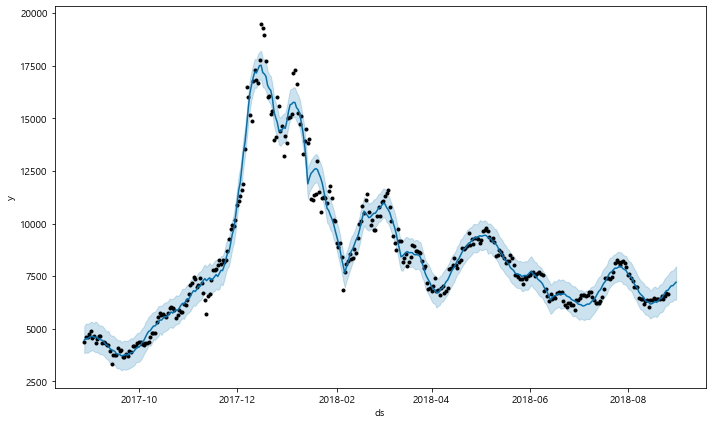

In [21]:
# 시각화.
prophet.plot(forecast_data)
plt.grid()
plt.show()

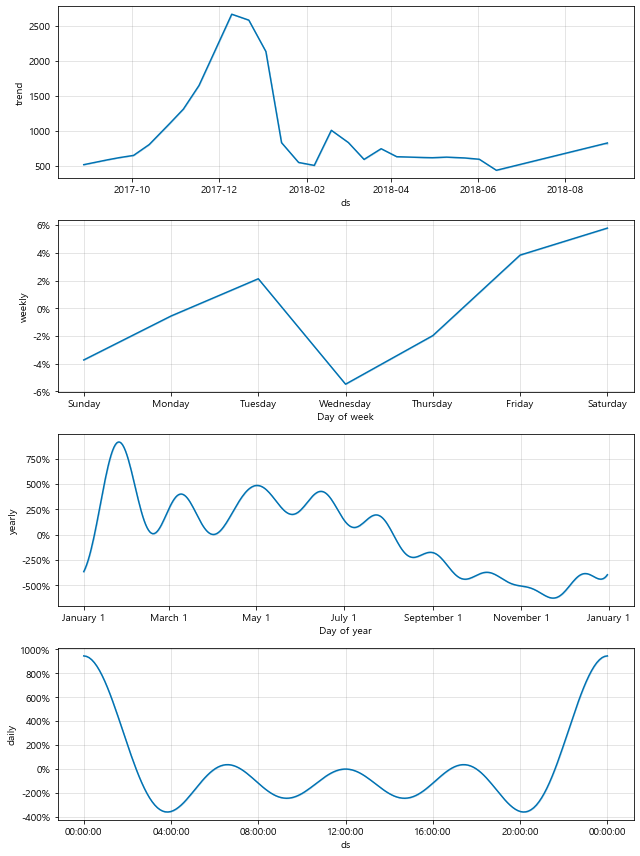

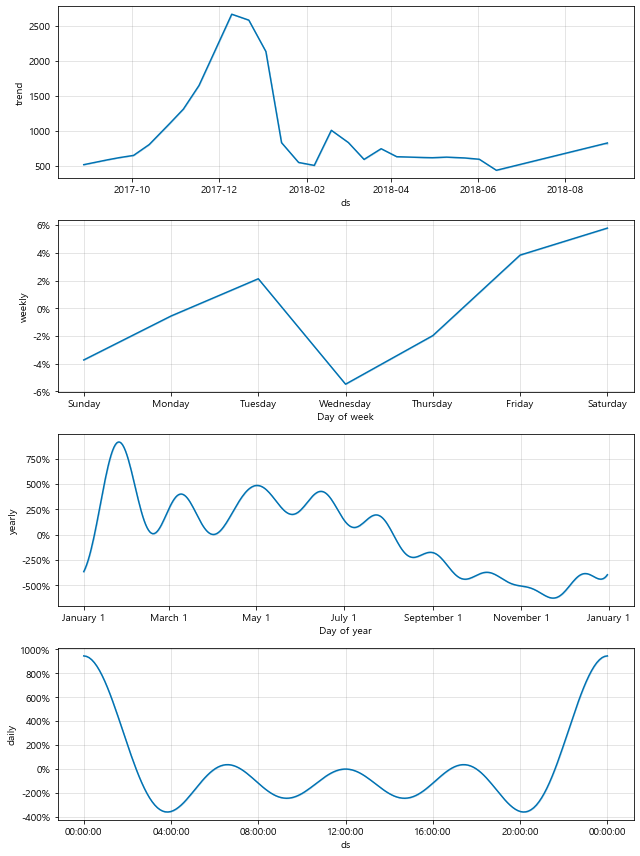

In [22]:
# 기간별 트랜드 분석 시각화.
prophet.plot_components(forecast_data)

In [23]:
# 가격 예측.
bitcon_test_df = pd.read_csv('data10/market-price-test.csv')
bitcon_test_df.columns = ['ds', 'y']
bitcon_test_df

,ds,y
0,2018-08-28 00:00:00,7000.040000
1,2018-08-29 00:00:00,7054.276429
2,2018-08-30 00:00:00,6932.662500
3,2018-08-31 00:00:00,6981.946154


In [24]:
# 예측 결과.
pred_y = forecast_data['yhat'].values[-5:]
# 실제 결과.
test_y = bitcon_test_df['y'].values
print(pred_y)
print(test_y)

[6939.83696126 7039.62014303 7045.0843904  7127.57742727 7214.21554205]
[7000.04       7054.27642857 6932.6625     6981.94615385]


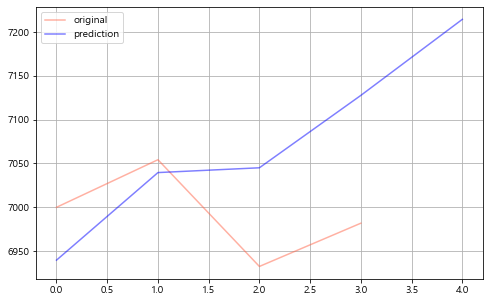

In [25]:
plt.plot(test_y, label='original', c='tomato', alpha=.5)
plt.plot(pred_y, label='prediction', c='blue', alpha=.5)
plt.legend()
plt.grid()
plt.show()